# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline                 

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab 2 data/train.p'
testing_file = 'lab 2 data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
print('Extracted training data..')
X_test, y_test = test['features'], test['labels']
print('Extracted test data..')

is_data_read = True

Extracted training data..
Extracted test data..


In [2]:
### To start off let's do a basic data summary.

assert is_data_read,'You failed to load the data'

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
#le = preprocessing.LabelEncoder()
#le.fit(y_train)
#n_classes = le.classes_.shape[0]
#n_classes = len(set(y_train))
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Image preprocessing is successful..
(9, 32, 32)


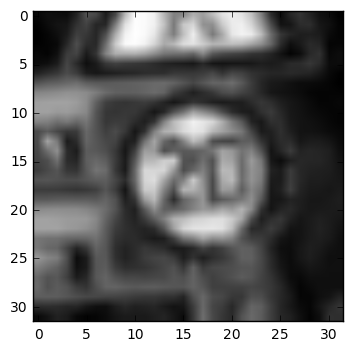

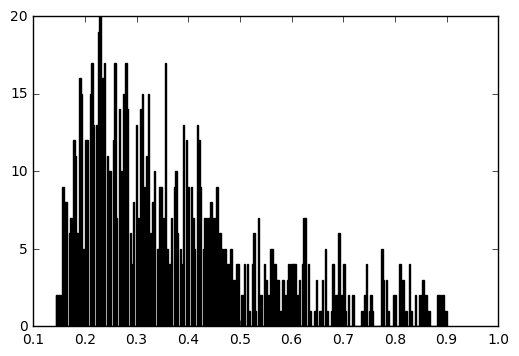

In [3]:
### Preprocess the data here.
# Normalize all images so that value are between -1 to 1
import cv2
from sklearn.preprocessing import scale, StandardScaler
image_value_ranges = [0.1,0.9]

def convert_rgb2yuv(image_data):
    yuv_image_data = []
    if len(image_data.shape) > 3: 
        for i in range(len(image_data)):
            yuv_image_data.append(cv2.cvtColor(image_data[i], cv2.COLOR_RGB2YUV))
    else:
        yuv_image_data.append(cv2.cvtColor(image_data, cv2.COLOR_RGB2YUV))
    return np.array(yuv_image_data)

def convert_rgb2gray(image_data):
    gray_image_data = []
    for i in range(len(image_data)):
        gray_image_data.append(cv2.cvtColor(image_data[i], cv2.COLOR_RGB2GRAY))
    return np.array(gray_image_data)

def normalize_Y_lecun(image_data):
    im_data = np.array(image_data,np.float32)
    #im_reshape = np.reshape(image_data,(-1,1024))
    #standard_scaler = StandardScaler(with_mean=True)
    #im_rescale = standard_scaler.fit_transform(im_reshape)
    #im_rescale = scale(im_reshape, axis=0, with_mean=True, with_std=False)
    #im_data = np.reshape(im_rescale,(-1,32,32))
    minV = np.amin(im_data)
    maxV = np.amax(im_data)
    lowerLimit = image_value_ranges[0]
    upperLimit = image_value_ranges[1]
    im_data =  lowerLimit + ((im_data - minV)*(upperLimit - lowerLimit))/(maxV - minV)
    return im_data

def normalize_Y(image_data,sub_mean = False,use_channel=False):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    minV = np.amin(image_data)
    maxV = np.amax(image_data)
    #minV = 0
    #maxV = 255
    lowerLimit = image_value_ranges[0]
    upperLimit = image_value_ranges[1]
    image_data = np.array(image_data,np.float32)
    image_data[:,:,:,0] =  lowerLimit + ((image_data[:,:,:,0] - minV)*(upperLimit - lowerLimit))/(maxV - minV)
    #image_data =  lowerLimit + ((image_data - minV)*(upperLimit - lowerLimit))/(maxV - minV)
    if sub_mean:
        image_data[:,:,:,0] = image_data[:,:,:,0] - np.mean(image_data[:,:,:,0], axis=0)
    if use_channel:
        return image_data
    else:
        return image_data[:,:,:,0]

def preprocess_images(image_data, use_only_y = True, use_mean = False):
    # Convert rgb color format to yuv format 
    p_image_data = convert_rgb2yuv(image_data)
    p_image_data = normalize_Y_lecun(p_image_data[:,:,:,0])
    
    #if use_only_y:
        #p_image_data = normalize_Y(p_image_data,use_channel=False)
    #else:
        #p_image_data = normalize_Y(p_image_data,use_channel=True)

    return p_image_data

def pre_process_images_test(image_data):
    p_image_data = convert_rgb2yuv(image_data)
    

print('Image preprocessing is successful..')
is_preprocess_defined = True

# Testing
samples = X_train[1:10] 
slabels = y_train[1:10]
norm_sample = preprocess_images(samples)
#print(t_mean.shape)
print(norm_sample.shape)
plt.figure()
plt.imshow(norm_sample[0],cmap='gray')
plt.figure()
_ = plt.hist(norm_sample[0].ravel(),bins=256, color='black')

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [4]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [5]:
assert is_preprocess_defined,'Preprocessing image functions not defined'

import skimage.transform as skimage_tf
import skimage.exposure as exposure

def shift_image_location(image, xoffset, yoffset):
    rows,cols, depth = image.shape
    tparam = skimage_tf.AffineTransform(translation = (xoffset,yoffset))
    out = skimage_tf.warp(image,tparam)
    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    # This conversion is required as OpenCV rgb2yuv does not accept float64
    return out.astype(np.float32)
    
# function to rotate images by given degrees
def rotate_image(image, degree):
    rows, cols, depth = image.shape
    rad = (np.pi / 180) * degree
    tparam = skimage_tf.AffineTransform(rotation = rad)
    out = skimage_tf.warp(image,tparam)
    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    return out.astype(np.float32)
    
# function to resize the image
def scale_image(image, ratio):
    rows, cols, depth = image.shape
    scale = skimage_tf.rescale(image,ratio)
    m_rows, m_cols, m_depth = scale.shape
    #print(ratio)
    #print(scale.shape)
    if ratio > 1.0:
        #print('GT')
        offset = m_rows - rows
        out = scale[offset:offset+rows, offset:offset+cols]
    else:
        #print('LT')
        out = np.zeros((rows,cols,depth))
        offset = rows - m_rows
        out[offset:offset+rows, offset:offset+cols] = scale
    
    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    return out.astype(np.float32)

def affine_image(image, xoffset, yoffset, degree, ratio):
    out = shift_image_location(image, xoffset, yoffset)
    out = rotate_image(out, degree)
    out = scale_image(out,ratio)
    return out.astype(np.float32)

def combined_operations(image, xoffset, yoffset, degree, ratio, choice):
    out = shift_image_location(image, xoffset, yoffset)
    out = rotate_image(out, degree)
    out = scale_image(out,ratio)
    out = change_intensity(out, choice)
    return out.astype(np.float32)

def change_intensity(image, choice):
    rows, cols, depth = image.shape
    if choice == 1:
        rnd = 2 * np.random.random()
        out = exposure.adjust_gamma(image,gamma=rnd)
    elif choice == 2:
        out = exposure.adjust_log(image)
    else:
        out = exposure.adjust_sigmoid(image)

    assert((out.shape[0] == 32) & (out.shape[1] == 32))
    return out.astype(np.float32)

def jitter_image_data(input_images,input_labels,batch_size):
    num_images = input_images.shape[0]
    jitter_images = []
    jitter_images_labels = [] 
    indx = np.random.choice(input_images.shape[0],batch_size,replace = False)
    images = input_images[indx]
    labels = input_labels[indx]
    for imageIdx in range(batch_size):
        xoffset = int(4 * np.random.random() - 2)
        yoffset = int(4 * np.random.random() - 2)
        degree = int (20 * np.random.random() - 10)
        ratio = 0.2 * np.random.random() + 0.9
        choice = np.random.randint(4)
        # Affine
        jitter_images.append(combined_operations(images[imageIdx], xoffset, yoffset, degree, ratio,choice))
        jitter_images_labels.append(labels[imageIdx])
    
    return preprocess_images(np.array(jitter_images)), np.array(jitter_images_labels)


def jitter_image_data_old(input_images,input_labels,batch_size):
    num_images = input_images.shape[0]
    jitter_images = []
    jitter_images_labels = [] 
    indx = np.random.choice(input_images.shape[0],batch_size,replace = False)
    images = input_images[indx]
    labels = input_labels[indx]
    for imageIdx in range(batch_size):
            xoffset = int(4 * np.random.random() - 2)
            yoffset = int(4 * np.random.random() - 2)
            degree = int (20 * np.random.random() - 10)
            ratio = 0.2 * np.random.random() + 0.9
            choice = np.random.randint(4)
            # Add original image to the jitter data
            jitter_images.append(images[imageIdx])
            jitter_images_labels.append(labels[imageIdx])
            # Shift image
            jitter_images.append(shift_image_location(images[imageIdx], xoffset, yoffset))
            jitter_images_labels.append(labels[imageIdx])
            # Rotate image
            jitter_images.append(rotate_image(images[imageIdx], degree))
            jitter_images_labels.append(labels[imageIdx])
            # Scale image
            jitter_images.append(scale_image(images[imageIdx], ratio))
            jitter_images_labels.append(labels[imageIdx])
            # Affine
            jitter_images.append(affine_image(images[imageIdx], xoffset, yoffset, degree, ratio))
            jitter_images_labels.append(labels[imageIdx])
            # Brightness
            jitter_images.append(change_intensity(images[imageIdx], choice))
            jitter_images_labels.append(labels[imageIdx])
    
    s_ind = np.random.choice(input_images.shape[0],batch_size)
    
    assert(len(s_ind) == batch_size)
    
    return preprocess_images(np.array(jitter_images)[s_ind]), np.array(jitter_images_labels)[s_ind]

# Testing
#samples = X_train[1:100] 
#slabels = y_train[1:100]
#out1, out2 = jitter_image_data(samples,slabels,32)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

print('Labels One-Hot Encoded')
is_labels_encod = True
is_train_test_split = False

Labels One-Hot Encoded


In [7]:
assert is_preprocess_defined, 'You skipped the step to preprocess the images'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

if not is_train_test_split:
    # Get randomized datasets for training and validation
    train_features, valid_features, train_labels, valid_labels = train_test_split(
        X_train,
        train_labels,
        test_size=0.05,
        random_state=832289)

    #test_features = preprocess_images(X_test)

    print('Training features and labels randomized and split.')
    print('Number of training images {}'.format(train_features.shape[0]))
    print('Number of validation images {}'.format(valid_features.shape[0]))
    print('Number of testing images {}'.format(X_test.shape[0]))

is_train_test_split = True

Training features and labels randomized and split.
Number of training images 37248
Number of validation images 1961
Number of testing images 12630


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
# set up tensorflow
import tensorflow as tf

#Placeholder definition
features = tf.placeholder(tf.float32, [None, 32, 32])
image = tf.reshape(features, [-1,32,32,1])
keep_prob = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32, [None, 43])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

def model_twolayers():
    endpoints = {}
    with tf.variable_scope('conv1') as scope:
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)
        endpoints['conv1'] = h_conv1
        endpoints['conv1_pool1'] = h_pool1
    
    with tf.variable_scope('conv2') as scope:
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)
        endpoints['conv2'] = h_conv2
        endpoints['conv2_pool2'] = h_pool2

    with tf.variable_scope('fc1') as scope:
        W_fc1 = weight_variable([8*8*64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        endpoints['fc1'] = h_fc1_drop
    
    with tf.variable_scope('fc2') as scope:
        W_fc2 = weight_variable([1024, 43])
        b_fc2 = bias_variable([43])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        endpoints['logits'] = logits
    
    return logits, endpoints

def model_fourlayers():
    endpoints = {}
    with tf.variable_scope('conv1') as scope:
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)
        endpoints['conv1'] = h_conv1
        endpoints['conv1_pool1'] = h_pool1
    
    with tf.variable_scope('conv2') as scope:
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)
        endpoints['conv2'] = h_conv2
        endpoints['conv2_pool2'] = h_pool2
    
    with tf.variable_scope('conv3') as scope:
        W_conv3 = weight_variable([5, 5, 64, 128])
        b_conv3 = bias_variable([128])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
        h_pool3 = max_pool_2x2(h_conv3)
        endpoints['conv3'] = h_conv3
        endpoints['conv3_pool3'] = h_pool3
    
    with tf.variable_scope('conv4') as scope:
        W_conv4 = weight_variable([3, 3, 128, 256])
        b_conv4 = bias_variable([256])
        h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
        h_pool4 = max_pool_2x2(h_conv4)
        endpoints['conv4'] = h_conv4
        endpoints['conv4_pool4'] = h_pool4

    with tf.variable_scope('fc1') as scope:
        W_fc1 = weight_variable([2*2*256, 512])
        b_fc1 = bias_variable([512])
        h_pool4_flat = tf.reshape(h_pool4, [-1, 2*2*256])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        endpoints['fc1'] = h_fc1_drop
    
    with tf.variable_scope('fc2') as scope:
        W_fc2 = weight_variable([512, 43])
        b_fc2 = bias_variable([43])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        endpoints['logits'] = logits
    
    return logits, endpoints

def loss(logits, labels):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
    return loss

def training(loss, learning_rate, name = 'Adam'):
    if name == 'GD':
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    else:
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer

def evaluation(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy


In [ ]:
print('Model Architecture for two layers is as follows')
_, conv_dict1 = model_twolayers()
conv_dict1

In [ ]:
print('Model Architecture for four layers is as follows')
_, conv_dict2 = model_fourlayers()
conv_dict2

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
import math
import time

def run_training(steps,batch_size,learning_rate,k_prob,use_jitter=False, modelname ='Two'):
    stime = time.time()
    sess = tf.InteractiveSession()

    if modelname == 'Four':
        logits, _ = model_fourlayers()
    else:
        logits, _ = model_twolayers()
    
    losses = loss(logits,labels)
    train_op = training(losses, learning_rate)
    acc = evaluation(logits,labels)
    tf.initialize_all_variables().run()
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    log_batch_step = 1000
    batches_history = []
       
    if not use_jitter:
        norm_train_features = preprocess_images(train_features)
    else:
        norm_train_features = train_features
    
    norm_valid_features = preprocess_images(valid_features)
    norn_test_features = preprocess_images(X_test[1:1000])
    
    valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}
    test_feed_dict = {features: norn_test_features, labels : test_labels[1:1000], keep_prob: 1}
    
    print('Training model with {} layers started for step: {} batchsize: {} learning_rate: {} keep_prob: {}'.format(modelname, steps,batch_size,learning_rate,k_prob))
    
    for step in range(steps):
        # Get a batch of training features and labels
        #batch_start = batch_i*batch_size
        #batch_features = train_features[batch_start:batch_start + batch_size]
        #batch_labels = train_labels[batch_start:batch_start + batch_size]
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)

        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})
                
        if step%log_batch_step == 0:
            train_accuracy = acc.eval(feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
            valid_accuracy = acc.eval(feed_dict=valid_feed_dict)
            test_accuracy = acc.eval(feed_dict=test_feed_dict)
            print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            previous_batch = batches_history[-1] if batches_history else 0
            batches_history.append(log_batch_step + previous_batch)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(valid_accuracy)
            loss_history.append(loss_value)
        
    # Check accuracy against Test data
    test_accuracy = sess.run(acc, feed_dict=test_feed_dict)
    
    print('Training completed with test accuracy : {}'.format(test_accuracy))
    
    return batches_history, train_acc_history, val_acc_history, test_accuracy

In [ ]:
# fine tuning hyperparameters
jit = [False]
models = ['Two']
#models = ['Four']
steps = [10000]
#batches = [64, 128, 256]
batches = [128]
#lr = [1e-2, 1e-3, 1e-4]
lr = [1e-3]
#kp = [0.5, 0.6, 0,7, 0.8]
kp = [0.5]
result = []
best_acc = 0.0
best_params = []
for j in jit:
    for m in models:
        for s in steps:
            for b in batches:
                for l in lr:
                    for k in kp:
                        batch_val, train_acc, val_acc, test_acc = run_training(s,b,l,k,j,m)
                        if test_acc > best_acc:
                            best_acc = test_acc
                            best_params = [s,b,l,k,m]
                            batch_best = batch_val
                            acc_best = [train_acc, val_acc]

print('Best Validation Accuracy : {}'.format(best_acc))
print('Best parameters: steps:{} batches:{} learning_rate:{} keep_prob:{}'.format(best_params[0],best_params[1],best_params[2],best_params[3]))

acc_plot = plt.subplot()
acc_plot.set_title('Accuracy')
acc_plot.plot(batch_best, acc_best[0], 'g', label='Training Accuracy')
acc_plot.plot(batch_best, acc_best[1], 'r', label='Validation Accuracy')
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()


In [ ]:
# fine tuning hyperparameters
# fine tuning hyperparameters
jit = [True]
models = ['Four']
steps = [10000]
batches = [64, 128]
lr = [1e-2, 1e-3, 1e-4]
kp = [0.5, 0.65, 0.8]
result = []
best_acc = 0.0
best_params = []
for j in jit:
    for m in models:
        for s in steps:
            for b in batches:
                for l in lr:
                    for k in kp:
                        batch_val, train_acc, val_acc, test_acc = run_training(s,b,l,k,j,m)
                        if test_acc > best_acc:
                            best_acc = test_acc
                            best_params = [s,b,l,k,m]
                            batch_best = batch_val
                            acc_best = [train_acc, val_acc]

print('Best Validation Accuracy : {}'.format(best_acc))
print('Best parameters: steps:{} batches:{} learning_rate:{} keep_prob:{}'.format(best_params[0],best_params[1],best_params[2],best_params[3]))

acc_plot = plt.subplot()
acc_plot.set_title('Accuracy')
acc_plot.plot(batch_best, acc_best[0], 'g', label='Training Accuracy')
acc_plot.plot(batch_best, acc_best[1], 'r', label='Validation Accuracy')
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [ ]:
#Placeholder definition
import tensorflow as tf
currGraph = tf.Graph()
with currGraph.as_default():
    features = tf.placeholder(tf.float32, [None, 32, 32])
    image = tf.reshape(features, [-1,32,32,1])
    keep_prob = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    def model_twolayers():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([8*8*64, 1024])
            b_fc1 = bias_variable([1024])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop

        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([1024, 43])
            b_fc2 = bias_variable([43])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            endpoints['logits'] = logits

        return logits, endpoints

    def model_fourlayers():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2

        with tf.variable_scope('conv3') as scope:
            W_conv3 = weight_variable([5, 5, 64, 128])
            b_conv3 = bias_variable([128])
            h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
            h_pool3 = max_pool_2x2(h_conv3)
            endpoints['conv3'] = h_conv3
            endpoints['conv3_pool3'] = h_pool3

        with tf.variable_scope('conv4') as scope:
            W_conv4 = weight_variable([3, 3, 128, 256])
            b_conv4 = bias_variable([256])
            h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
            h_pool4 = max_pool_2x2(h_conv4)
            endpoints['conv4'] = h_conv4
            endpoints['conv4_pool4'] = h_pool4

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([2*2*256, 512])
            b_fc1 = bias_variable([512])
            h_pool4_flat = tf.reshape(h_pool4, [-1, 2*2*256])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop

        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([512, 43])
            b_fc2 = bias_variable([43])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            endpoints['logits'] = logits

        return logits, endpoints

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

print('Graph session created to train a longer model')

In [ ]:
import os
import math
curr_path = os.getcwd()
save_path = curr_path +'/models/model.ckpt-99999'
use_jitter = False
steps = 100000
batch_size = 128
k_prob = 0.5
learning_rate = 0.001

# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}
#test_feed_dict = {features: norm_test_features[1:1000], labels : test_labels[1:1000], keep_prob: 1}

restore_model = 1


with currGraph.as_default():  
    logits, _ = model_twolayers()
    losses = loss(logits,labels)
    train_op = training(losses, learning_rate)
    acc = evaluation(logits,labels)
    init = tf.initialize_all_variables()
    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    # Create a session for running Ops on the Graph.
    sess = tf.Session()
    # Run the Op to initialize the variables.
        #use the previous model or don't and initialize variables
    if restore_model:
        saver.restore(sess,save_path)
        print("Model restored.")
    else:
        sess.run(init)
    
    if 0:
    
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
            # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})

            if step%100 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                    #print(total)
                #print(total,n_test)
                test_accuracy = total / batch_count
                #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))
            if ((step == (steps-1)) or (test_accuracy > 0.99)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,save_path, global_step=step)
                print("Model saved.")
    else:
        print('Success')

In [ ]:
import os
import math
curr_path = os.getcwd()
save_path = curr_path +'/model_jitter.ckpt'
use_jitter = True
steps = 100000
batch_size = 64
k_prob = 0.65
learning_rate = 0.001

# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}
#test_feed_dict = {features: norm_test_features[1:1000], labels : test_labels[1:1000], keep_prob: 1}

restore_model = 0


with currGraph.as_default():
     
    #use the previous model or don't and initialize variables
    if restore_model:
        saver.restore(sess,save_path)
        print("Model restored.")
    
    logits, _ = model_twolayers()
    losses = loss(logits,labels)
    train_op = training(losses, learning_rate)
    acc = evaluation(logits,labels)
    init = tf.initialize_all_variables()
    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    # Create a session for running Ops on the Graph.
    sess = tf.Session()
    # Run the Op to initialize the variables.
    sess.run(init)    
    
    for step in range(steps):
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})

        if step%100 == 0:
            train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
            valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
            batch_count = int(math.ceil(n_test/batch_size))
            total = 0
            for i in range(batch_count):
                batch_start = i*batch_size
                test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                #print(total)
            #print(total,n_test)
            test_accuracy = total / batch_count
            #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))
            
        if ((step == (steps-1)) or (test_accuracy > 0.99)):
            batch_count = int(math.ceil(n_test/batch_size))
            total = 0
            for i in range(batch_count):
                batch_start = i*batch_size
                test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
            test_accuracy = total / batch_count
            print('Final test accuracy: {}'.format(test_accuracy))
            save_path = saver.save(sess,save_path, global_step=step)
            print("Model saved.")

In [ ]:
import os
import math
curr_path = os.getcwd()
save_path = curr_path +'/modelFour_jitter.ckpt'
use_jitter = True
steps = 100000
batch_size = 128
k_prob = 0.65
learning_rate = 0.0001

# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}
#test_feed_dict = {features: norm_test_features[1:1000], labels : test_labels[1:1000], keep_prob: 1}

restore_model = 0


with currGraph.as_default():
     
    #use the previous model or don't and initialize variables
    if restore_model:
        saver.restore(sess,save_path)
        print("Model restored.")
    
    logits, _ = model_fourlayers()
    losses = loss(logits,labels)
    train_op = training(losses, learning_rate)
    acc = evaluation(logits,labels)
    init = tf.initialize_all_variables()
    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    # Create a session for running Ops on the Graph.
    sess = tf.Session()
    # Run the Op to initialize the variables.
    sess.run(init)    
    
    for step in range(steps):
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})

        if step%100 == 0:
            train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
            valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
            batch_count = int(math.ceil(n_test/batch_size))
            total = 0
            for i in range(batch_count):
                batch_start = i*batch_size
                test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                #print(total)
            #print(total,n_test)
            test_accuracy = total / batch_count
            #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))
            
        if ((step == (steps-1)) or (test_accuracy > 0.99)):
            batch_count = int(math.ceil(n_test/batch_size))
            total = 0
            for i in range(batch_count):
                batch_start = i*batch_size
                test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
            test_accuracy = total / batch_count
            print('Final test accuracy: {}'.format(test_accuracy))
            save_path = saver.save(sess,save_path, global_step=step)
            print("Model saved.")

In [ ]:
#Placeholder definition
import tensorflow as tf
currGraph_color = tf.Graph()
with currGraph_color.as_default():
    features = tf.placeholder(tf.float32, [None, 32, 32, 3])
    image = tf.reshape(features, [-1,32,32,3])
    keep_prob = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    def model_twolayers():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 3, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([8*8*64, 1024])
            b_fc1 = bias_variable([1024])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop

        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([1024, 43])
            b_fc2 = bias_variable([43])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            endpoints['logits'] = logits

        return logits, endpoints

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy

print('Graph session created to train a longer model')

In [ ]:
import os
import math
curr_path = os.getcwd()
save_path = curr_path +'/color_model_jitter.ckpt'
use_jitter = True
steps = 100000
batch_size = 128
k_prob = 0.5
learning_rate = 0.001

# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}
#test_feed_dict = {features: norm_test_features[1:1000], labels : test_labels[1:1000], keep_prob: 1}

restore_model = 0


with currGraph_color.as_default():
     
    #use the previous model or don't and initialize variables
    if restore_model:
        saver.restore(sess,save_path)
        print("Model restored.")
    
    logits, _ = model_twolayers()
    losses = loss(logits,labels)
    train_op = training(losses, learning_rate)
    acc = evaluation(logits,labels)
    init = tf.initialize_all_variables()
    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    # Create a session for running Ops on the Graph.
    sess = tf.Session()
    # Run the Op to initialize the variables.
    sess.run(init)    
    
    for step in range(steps):
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})

        if step%100 == 0:
            train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
            valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
            batch_count = int(math.ceil(n_test/batch_size))
            total = 0
            for i in range(batch_count):
                batch_start = i*batch_size
                test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                #print(total)
            #print(total,n_test)
            test_accuracy = total / batch_count
            #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))
            
        if ((step == (steps-1)) or (test_accuracy > 0.99)):
            batch_count = int(math.ceil(n_test/batch_size))
            total = 0
            for i in range(batch_count):
                batch_start = i*batch_size
                test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
            test_accuracy = total / batch_count
            print('Final test accuracy: {}'.format(test_accuracy))
            save_path = saver.save(sess,save_path, global_step=step)
            print("Model saved.")

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import os
import math
curr_path = os.getcwd()
save_path = curr_path +'/color_model_jitter.ckpt-99999'

def read_new_images():
    processed_images = []
    for image_name in glob.glob('images/*.jpg'):
        image = cv2.imread(image_name)
        resize_image = cv2.resize(image,(32,32))
        processed_images.append(resize_image)

    return(preprocess_images(np.array(processed_images)))
    
new_test_images = read_new_images()

curr_path = os.getcwd()
save_path = curr_path +'/models/model.ckpt-99999'

with tf.Session(graph=currGraph) as sess:
    logits, _ = model_twolayers()
    losses = loss(logits,labels)
    train_op = training(losses, 0.001)
    acc = evaluation(logits,labels)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()
    saver.restore(sess,save_path)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [ ]:
#http://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
import glob
from matplotlib import gridspec
curr_path = os.getcwd()
model_path = curr_path +'/models/model_simple.ckpt'
def read_new_images():
    processed_images = []
    for image_name in glob.glob('images/*.jpg'):
        image = cv2.imread(image_name)
        resize_image = cv2.resize(image,(32,32))
        processed_images.append(resize_image)

    return(preprocess_images(np.array(processed_images)))
    
new_test_images = read_new_images()
with tf.Session(graph=graph_model_simple) as sess:
    saver.restore(sess,model_path)
    pred_value, pred_class_value = sess.run([pred,pred_class],feed_dict={features:new_test_images,keep_prob:1})


num_new_test_images = pred_value.shape[0]
num_class_labels = pred_value.shape[1]
# Due to memory constraint, displaying only 5 images
rand_idx = np.random.choice(num_new_test_images,5)
sample_prob = pred_value[rand_idx]
sample_class = pred_class_value.indices[rand_idx]
index = np.arange(num_class_labels)
for idx in range(5):
    fig = plt.figure(figsize=(10, 10)) 
    gs = gridspec.GridSpec(1, 2, height_ratios=[1, 5])
    ax0 = plt.subplot(gs[0])
    ax0.imshow(new_test_images[idx],cmap='gray')
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = plt.subplot(gs[1])
    ax1.bar(index, pred_value[idx])

In [ ]:
#Placeholder definition
import tensorflow as tf
graph_model_multi = tf.Graph()

with graph_model_multi.as_default():
    
    features = tf.placeholder(tf.float32, [None, 32, 32])
    image = tf.reshape(features, [-1,32,32,1])
    keep_prob = tf.placeholder(tf.float32)
    lr_value = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
    # normalize
    def norm(x):
        return tf.nn.lrn(x, 4, bias=1.0, alpha=0.001/9.00, beta=0.75)

    def model():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 8])
            b_conv1 = bias_variable([8])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 8, 16])
            b_conv2 = bias_variable([16])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2
        
        with tf.variable_scope('combined') as scope:
            h_pool1_flat = tf.reshape(h_pool1, [-1, 16*16*8])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*16])
            print("h_pool1_flat:",h_pool1_flat.get_shape())
            print("h_pool2_flat:",h_pool2_flat.get_shape())
            combined_pool_flat = tf.concat(1, [h_pool1_flat, h_pool2_flat])
            combined_pool_flat_shape = combined_pool_flat.get_shape()[1].value
            print("combined_pool_flat:",combined_pool_flat.get_shape())
            print("combined_pool_flat_shape:",combined_pool_flat_shape)
            endpoints['combined'] = combined_pool_flat
    
        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([combined_pool_flat_shape, 1024])
            b_fc1 = bias_variable([1024])
            h_fc1 = tf.nn.relu(tf.matmul(combined_pool_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop
        
        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([1024, 100])
            b_fc2 = bias_variable([100])
            h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
            h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)
            endpoints['fc2'] = h_fc2_drop
            
        with tf.variable_scope('fc3') as scope:
            W_fc3 = weight_variable([100, 43])
            b_fc3 = bias_variable([43])
            logits = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
            endpoints['logits'] = logits

        return logits, endpoints        

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def prediction_prob(logits):
        return tf.nn.softmax(logits)
    
    def prediction_class(logits):
        return tf.nn.top_k(logits)
    
    logits, graphdef = model()
    losses = loss(logits,labels)
    train_op = training(losses, lr_value)
    acc = evaluation(logits,labels)
    pred = prediction_prob(logits)
    pred_class = prediction_class(logits)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

print('MultiScale model defined..')
graphdef

In [8]:
import math
import time

def run_training(steps,batch_size,learning_rate,k_prob,use_jitter=False, modelname ='Two'):
    stime = time.time()
    sess = tf.Session(graph=graph_model_multi2)
    sess.run(init)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    log_batch_step = 1000
    batches_history = []
       
    if not use_jitter:
        norm_train_features = preprocess_images(train_features)
    else:
        norm_train_features = train_features
    
    norm_valid_features = preprocess_images(valid_features)
    norn_test_features = preprocess_images(X_test[1:1000])
    
    valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob, lr_value: learning_rate}
    test_feed_dict = {features: norn_test_features, labels : test_labels[1:1000], keep_prob: 1, lr_value: learning_rate}
    
    print('Training model with {} layers started for step: {} batchsize: {} learning_rate: {} keep_prob: {}'.format(modelname, steps,batch_size,learning_rate,k_prob))
    
    for step in range(steps):
        # Get a batch of training features and labels
        #batch_start = batch_i*batch_size
        #batch_features = train_features[batch_start:batch_start + batch_size]
        #batch_labels = train_labels[batch_start:batch_start + batch_size]
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)

        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob, lr_value: learning_rate})
                
        if step%log_batch_step == 0:
            train_accuracy = sess.run(acc, feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1, lr_value:learning_rate})
            valid_accuracy = sess.run(acc, feed_dict=valid_feed_dict)
            test_accuracy = sess.run(acc, feed_dict=test_feed_dict)
            print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            previous_batch = batches_history[-1] if batches_history else 0
            batches_history.append(log_batch_step + previous_batch)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(valid_accuracy)
            loss_history.append(loss_value)
        
    # Check accuracy against Test data
    test_accuracy = sess.run(acc, feed_dict=test_feed_dict)
    
    print('Training completed with test accuracy : {}'.format(test_accuracy))
    
    return batches_history, train_acc_history, val_acc_history, test_accuracy

In [ ]:
# fine tuning hyperparameters
jit = [False]
models = ['Two']
#models = ['Four']
steps = [10000]
batches = [64, 128, 256]
#batches = [128]
lr = [1e-3, 1e-4]
#lr = [1e-2, 1e-3]
kp = [0.5, 0.65, 0.8]
#kp = [0.5]
result = []
best_acc = 0.0
best_params = []
for j in jit:
    for m in models:
        for s in steps:
            for b in batches:
                for l in lr:
                    for k in kp:
                        batch_val, train_acc, val_acc, test_acc = run_training(s,b,l,k,j,m)
                        if test_acc > best_acc:
                            best_acc = test_acc
                            best_params = [s,b,l,k,m]
                            batch_best = batch_val
                            acc_best = [train_acc, val_acc]

print('Best Validation Accuracy : {}'.format(best_acc))
print('Best parameters: steps:{} batches:{} learning_rate:{} keep_prob:{}'.format(best_params[0],best_params[1],best_params[2],best_params[3]))

acc_plot = plt.subplot()
acc_plot.set_title('Accuracy')
acc_plot.plot(batch_best, acc_best[0], 'g', label='Training Accuracy')
acc_plot.plot(batch_best, acc_best[1], 'r', label='Validation Accuracy')
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [ ]:
#Placeholder definition
import tensorflow as tf
graph_model_multi_others = tf.Graph()

with graph_model_multi_others.as_default():
    
    features = tf.placeholder(tf.float32, [None, 32, 32])
    image = tf.reshape(features, [-1,32,32,1])
    keep_prob = tf.placeholder(tf.float32)
    lr_value = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')
    # normalize
    def norm(x):
        return tf.nn.lrn(x, 4, bias=1.0, alpha=0.001/9.00, beta=0.75)
    
    def model1():
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)
        h_norm1 = norm(h_pool1)
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_norm1, W_conv2) + b_conv2)
        h_norm2 = norm(h_conv2)
        h_pool2 = max_pool_2x2(h_norm2)
        W_conv3 = weight_variable([3, 3, 64, 128])
        b_conv3 = bias_variable([128])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
        h_pool3 = max_pool_2x2(h_conv3)
        h_norm3 = norm(h_pool3)
        W_conv4 = weight_variable([1, 1, 128, 256])
        b_conv4 = bias_variable([256])
        h_conv4 = tf.nn.relu(conv2d(h_norm3, W_conv4) + b_conv4)
        h_norm4 = norm(h_conv4)
        h_pool4 = max_pool_2x2(h_norm4)
        h_pool3_flat = tf.reshape(h_norm3, [-1, 4*4*128])
        h_pool4_flat = tf.reshape(h_pool4, [-1, 2*2*256])
        print("h_pool3_flat: ", h_pool3_flat.get_shape())
        print("h_pool4_flat: ", h_pool4_flat.get_shape())
        combined_flat = tf.concat(1, [h_pool3_flat, h_pool4_flat])
        dim = combined_flat.get_shape()[1].value
        print("combined_flat: ", combined_flat.get_shape())
        W_fc1 = weight_variable([dim, 1024])
        b_fc1 = bias_variable([1024])
        h_fc1 = tf.nn.relu(tf.matmul(combined_flat, W_fc1) + b_fc1)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        W_fc2 = weight_variable([1024, 43])
        b_fc2 = bias_variable([43])
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        
        return y_conv
        

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def prediction_prob(logits):
        return tf.nn.softmax(logits)
    
    def prediction_class(logits):
        return tf.nn.top_k(logits)
    
    #logits, graphdef = model()
    logits = model1()
    losses = loss(logits,labels)
    train_op = training(losses, lr_value)
    acc = evaluation(logits,labels)
    pred = prediction_prob(logits)
    pred_class = prediction_class(logits)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

print('MultiScale model defined..')

In [ ]:
import math
import time

def run_training(steps,batch_size,learning_rate,k_prob,use_jitter=False, modelname ='Two'):
    stime = time.time()
    sess = tf.Session(graph=graph_model_multi_others)
    sess.run(init)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    log_batch_step = 1000
    batches_history = []
       
    if not use_jitter:
        norm_train_features = preprocess_images(train_features)
    else:
        norm_train_features = train_features
    
    norm_valid_features = preprocess_images(valid_features)
    norn_test_features = preprocess_images(X_test[1:1000])
    
    valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob, lr_value: learning_rate}
    test_feed_dict = {features: norn_test_features, labels : test_labels[1:1000], keep_prob: 1, lr_value: learning_rate}
    
    print('Training model with {} layers started for step: {} batchsize: {} learning_rate: {} keep_prob: {}'.format(modelname, steps,batch_size,learning_rate,k_prob))
    
    for step in range(steps):
        # Get a batch of training features and labels
        #batch_start = batch_i*batch_size
        #batch_features = train_features[batch_start:batch_start + batch_size]
        #batch_labels = train_labels[batch_start:batch_start + batch_size]
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)

        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob, lr_value: learning_rate})
                
        if step%log_batch_step == 0:
            train_accuracy = sess.run(acc, feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1, lr_value:learning_rate})
            valid_accuracy = sess.run(acc, feed_dict=valid_feed_dict)
            test_accuracy = sess.run(acc, feed_dict=test_feed_dict)
            print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            previous_batch = batches_history[-1] if batches_history else 0
            batches_history.append(log_batch_step + previous_batch)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(valid_accuracy)
            loss_history.append(loss_value)
        
    # Check accuracy against Test data
    test_accuracy = sess.run(acc, feed_dict=test_feed_dict)
    
    print('Training completed with test accuracy : {}'.format(test_accuracy))
    
    return batches_history, train_acc_history, val_acc_history, test_accuracy

In [ ]:
# fine tuning hyperparameters
jit = [False]
models = ['Two']
#models = ['Four']
steps = [10000]
batches = [32, 64, 128]
#batches = [128]
#lr = [1e-2, 1e-3, 1e-4]
lr = [1e-2, 1e-3]
kp = [0.5, 0.65, 0.8]
#kp = [0.5]
result = []
best_acc = 0.0
best_params = []
for j in jit:
    for m in models:
        for s in steps:
            for b in batches:
                for l in lr:
                    for k in kp:
                        batch_val, train_acc, val_acc, test_acc = run_training(s,b,l,k,j,m)
                        if test_acc > best_acc:
                            best_acc = test_acc
                            best_params = [s,b,l,k,m]
                            batch_best = batch_val
                            acc_best = [train_acc, val_acc]

print('Best Validation Accuracy : {}'.format(best_acc))
print('Best parameters: steps:{} batches:{} learning_rate:{} keep_prob:{}'.format(best_params[0],best_params[1],best_params[2],best_params[3]))

acc_plot = plt.subplot()
acc_plot.set_title('Accuracy')
acc_plot.plot(batch_best, acc_best[0], 'g', label='Training Accuracy')
acc_plot.plot(batch_best, acc_best[1], 'r', label='Validation Accuracy')
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [8]:
#Placeholder definition
import tensorflow as tf
graph_model_multi2 = tf.Graph()

with graph_model_multi2.as_default():
    
    features = tf.placeholder(tf.float32, [None, 32, 32])
    image = tf.reshape(features, [-1,32,32,1])
    keep_prob = tf.placeholder(tf.float32)
    lr_value = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    def model():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2
        
        with tf.variable_scope('combined') as scope:
            h_pool1_flat = tf.reshape(h_pool1, [-1, 16*16*32])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
            combined_pool_flat = tf.concat(1, [h_pool1_flat, h_pool2_flat])
            combined_pool_flat_shape = combined_pool_flat.get_shape()[1].value
            endpoints['combined'] = combined_pool_flat

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([combined_pool_flat_shape, 1024])
            b_fc1 = bias_variable([1024])
            h_fc1 = tf.nn.relu(tf.matmul(combined_pool_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop
        
        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([1024, 100])
            b_fc2 = bias_variable([100])
            h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
            h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)
            endpoints['fc2'] = h_fc2_drop
            
        with tf.variable_scope('fc3') as scope:
            W_fc3 = weight_variable([100, 43])
            b_fc3 = bias_variable([43])
            logits = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
            endpoints['logits'] = logits

        return logits, endpoints

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def prediction_prob(logits):
        return tf.nn.softmax(logits)
    
    def prediction_class(logits):
        return tf.nn.top_k(logits)
    
    logits, _ = model()
    losses = loss(logits,labels)
    train_op = training(losses, lr_value)
    acc = evaluation(logits,labels)
    pred = prediction_prob(logits)
    pred_class = prediction_class(logits)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

print('MultiScale model2 defined..')

MultiScale model2 defined..


In [ ]:
import math
import time

def run_training(steps,batch_size,learning_rate,k_prob,use_jitter=False, modelname ='Two'):
    stime = time.time()
    sess = tf.Session(graph=graph_model_multi2)
    sess.run(init)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    log_batch_step = 1000
    batches_history = []
       
    if not use_jitter:
        norm_train_features = preprocess_images(train_features)
    else:
        norm_train_features = train_features
    
    norm_valid_features = preprocess_images(valid_features)
    norn_test_features = preprocess_images(X_test[1:1000])
    
    valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}
    test_feed_dict = {features: norn_test_features, labels : test_labels[1:1000], keep_prob: 1}
    
    print('Training model with {} layers started for step: {} batchsize: {} learning_rate: {} keep_prob: {}'.format(modelname, steps,batch_size,learning_rate,k_prob))
    
    for step in range(steps):
        # Get a batch of training features and labels
        #batch_start = batch_i*batch_size
        #batch_features = train_features[batch_start:batch_start + batch_size]
        #batch_labels = train_labels[batch_start:batch_start + batch_size]
        batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
        batch_features = norm_train_features[batch_start]
        batch_labels = train_labels[batch_start]
        if use_jitter:
            batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)

        # Run optimizer
        loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})
                
        if step%log_batch_step == 0:
            train_accuracy = acc.eval(feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
            valid_accuracy = acc.eval(feed_dict=valid_feed_dict)
            test_accuracy = acc.eval(feed_dict=test_feed_dict)
            print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
            previous_batch = batches_history[-1] if batches_history else 0
            batches_history.append(log_batch_step + previous_batch)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(valid_accuracy)
            loss_history.append(loss_value)
        
    # Check accuracy against Test data
    test_accuracy = sess.run(acc, feed_dict=test_feed_dict)
    
    print('Training completed with test accuracy : {}'.format(test_accuracy))
    
    return batches_history, train_acc_history, val_acc_history, test_accuracy

In [ ]:
# fine tuning hyperparameters
jit = [False]
models = ['Two']
#models = ['Four']
steps = [10000]
batches = [64, 128, 256]
#batches = [128]
#lr = [1e-2, 1e-3, 1e-4]
lr = [1e-2, 1e-3]
kp = [0.5, 0.65, 0.8]
kp = [0.5]
result = []
best_acc = 0.0
best_params = []
for j in jit:
    for m in models:
        for s in steps:
            for b in batches:
                for l in lr:
                    for k in kp:
                        batch_val, train_acc, val_acc, test_acc = run_training(s,b,l,k,j,m)
                        if test_acc > best_acc:
                            best_acc = test_acc
                            best_params = [s,b,l,k,m]
                            batch_best = batch_val
                            acc_best = [train_acc, val_acc]

print('Best Validation Accuracy : {}'.format(best_acc))
print('Best parameters: steps:{} batches:{} learning_rate:{} keep_prob:{}'.format(best_params[0],best_params[1],best_params[2],best_params[3]))

acc_plot = plt.subplot()
acc_plot.set_title('Accuracy')
acc_plot.plot(batch_best, acc_best[0], 'g', label='Training Accuracy')
acc_plot.plot(batch_best, acc_best[1], 'r', label='Validation Accuracy')
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

In [ ]:
#Placeholder definition
import tensorflow as tf
graph_model_simple = tf.Graph()

with graph_model_simple.as_default():
    
    features = tf.placeholder(tf.float32, [None, 32, 32])
    image = tf.reshape(features, [-1,32,32,1])
    keep_prob = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32, [None, 43])

    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME')

    def model_twolayers():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([8*8*64, 1024])
            b_fc1 = bias_variable([1024])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop

        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([1024, 43])
            b_fc2 = bias_variable([43])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            endpoints['logits'] = logits

        return logits, endpoints

    def model_fourlayers():
        endpoints = {}
        with tf.variable_scope('conv1') as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
            h_pool1 = max_pool_2x2(h_conv1)
            endpoints['conv1'] = h_conv1
            endpoints['conv1_pool1'] = h_pool1

        with tf.variable_scope('conv2') as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = max_pool_2x2(h_conv2)
            endpoints['conv2'] = h_conv2
            endpoints['conv2_pool2'] = h_pool2

        with tf.variable_scope('conv3') as scope:
            W_conv3 = weight_variable([5, 5, 64, 128])
            b_conv3 = bias_variable([128])
            h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
            h_pool3 = max_pool_2x2(h_conv3)
            endpoints['conv3'] = h_conv3
            endpoints['conv3_pool3'] = h_pool3

        with tf.variable_scope('conv4') as scope:
            W_conv4 = weight_variable([3, 3, 128, 256])
            b_conv4 = bias_variable([256])
            h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
            h_pool4 = max_pool_2x2(h_conv4)
            endpoints['conv4'] = h_conv4
            endpoints['conv4_pool4'] = h_pool4

        with tf.variable_scope('fc1') as scope:
            W_fc1 = weight_variable([2*2*256, 512])
            b_fc1 = bias_variable([512])
            h_pool4_flat = tf.reshape(h_pool4, [-1, 2*2*256])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool4_flat, W_fc1) + b_fc1)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
            endpoints['fc1'] = h_fc1_drop

        with tf.variable_scope('fc2') as scope:
            W_fc2 = weight_variable([512, 43])
            b_fc2 = bias_variable([43])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            endpoints['logits'] = logits

        return logits, endpoints

    def loss(logits, labels):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        return loss

    def training(loss, learning_rate, name = 'Adam'):
        if name == 'GD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        else:
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

        return optimizer

    def evaluation(logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def prediction_prob(logits):
        return tf.nn.softmax(logits)
    
    def prediction_class(logits):
        return tf.nn.top_k(logits)
    
    logits, _ = model_twolayers()
    losses = loss(logits,labels)
    train_op = training(losses, 0.001)
    acc = evaluation(logits,labels)
    pred = prediction_prob(logits)
    pred_class = prediction_class(logits)
    init = tf.initialize_all_variables()
    saver = tf.train.Saver()

In [ ]:
import os
import math
curr_path = os.getcwd()
model_path = curr_path +'/models/model_simple_jitter.ckpt'

train = True
use_jitter = True
steps = 100000
batch_size = 128
k_prob = 0.6
learning_rate = 0.001
# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}

#sess = tf.Session(graph=graph_model_simple)
#sess.run(init)
with tf.Session(graph=graph_model_simple) as sess:
    if train:
        sess.run(init)
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
                # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})

            if step%1000 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                    #print(total)
                #print(total,n_test)
                test_accuracy = total / batch_count
                #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))

            if ((step == (steps-1)) or (test_accuracy > 0.98)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,model_path)
                print("Model saved.")
    else:
        # Here's where you're restoring the variables w and b.
        # Note that the graph is exactly as it was when the variables were
        # saved in a prior training run.
        #ckpt = tf.train.get_checkpoint_state(check_dir)
        #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #print('Model Restored..')
        saver.restore(sess,model_path)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
        test_accuracy = total / batch_count
        print('Restored test accuracy: {}'.format(test_accuracy))

In [ ]:
import os
import math
curr_path = os.getcwd()
model_path = curr_path +'/models/model_simple_jitter2.ckpt'

train = True
use_jitter = True
steps = 100000
batch_size = 64
k_prob = 0.6
learning_rate = 0.0001
# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob}

#sess = tf.Session(graph=graph_model_simple)
#sess.run(init)
with tf.Session(graph=graph_model_simple) as sess:
    if train:
        sess.run(init)
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
                # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob})

            if step%1000 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                    #print(total)
                #print(total,n_test)
                test_accuracy = total / batch_count
                #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))

            if ((step == (steps-1)) or (test_accuracy > 0.98)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,model_path)
                print("Model saved.")
    else:
        # Here's where you're restoring the variables w and b.
        # Note that the graph is exactly as it was when the variables were
        # saved in a prior training run.
        #ckpt = tf.train.get_checkpoint_state(check_dir)
        #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #print('Model Restored..')
        saver.restore(sess,model_path)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
        test_accuracy = total / batch_count
        print('Restored test accuracy: {}'.format(test_accuracy))

In [ ]:
import os
import math
curr_path = os.getcwd()
model_path = curr_path +'/models/model_multi_1.ckpt'

train = True
use_jitter = False
steps = 100000
batch_size = 128
k_prob = 0.5
learning_rate = 0.001
# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob, lr_value: learning_rate}

#sess = tf.Session(graph=graph_model_simple)
#sess.run(init)
with tf.Session(graph=graph_model_multi3) as sess:
    if train:
        sess.run(init)
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
                # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob, lr_value: learning_rate})

            if step%1000 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1, lr_value: learning_rate})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
                    #print(total)
                #print(total,n_test)
                test_accuracy = total / batch_count
                #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))

            if ((step == (steps-1)) or (test_accuracy > 0.98)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value:learning_rate})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,model_path)
                print("Model saved.")
    else:
        # Here's where you're restoring the variables w and b.
        # Note that the graph is exactly as it was when the variables were
        # saved in a prior training run.
        #ckpt = tf.train.get_checkpoint_state(check_dir)
        #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #print('Model Restored..')
        saver.restore(sess,model_path)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
        test_accuracy = total / batch_count
        print('Restored test accuracy: {}'.format(test_accuracy))

In [ ]:
import os
import math
curr_path = os.getcwd()
model_path = curr_path +'/models/model_multi_jitter.ckpt'

train = True
use_jitter = True
steps = 100000
batch_size = 128
k_prob = 0.65
learning_rate = 0.001
# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob, lr_value: learning_rate}

#sess = tf.Session(graph=graph_model_simple)
#sess.run(init)
with tf.Session(graph=graph_model_multi) as sess:
    if train:
        sess.run(init)
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
                # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob, lr_value: learning_rate})

            if step%1000 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1, lr_value: learning_rate})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
                    #print(total)
                #print(total,n_test)
                test_accuracy = total / batch_count
                #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))

            if ((step == (steps-1)) or (test_accuracy > 0.98)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value:learning_rate})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,model_path)
                print("Model saved.")
    else:
        # Here's where you're restoring the variables w and b.
        # Note that the graph is exactly as it was when the variables were
        # saved in a prior training run.
        #ckpt = tf.train.get_checkpoint_state(check_dir)
        #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #print('Model Restored..')
        saver.restore(sess,model_path)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1})
        test_accuracy = total / batch_count
        print('Restored test accuracy: {}'.format(test_accuracy))

In [ ]:
import os
import math
curr_path = os.getcwd()
model_path = curr_path +'/models/model_multi.ckpt'

train = True
use_jitter = False
steps = 100000
batch_size = 96
k_prob = 0.5
learning_rate = 0.001
# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob, lr_value: learning_rate}

#sess = tf.Session(graph=graph_model_simple)
#sess.run(init)
with tf.Session(graph=graph_model_multi2) as sess:
    if train:
        sess.run(init)
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
                # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob, lr_value: learning_rate})

            if step%1000 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1, lr_value: learning_rate})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
                    #print(total)
                #print(total,n_test)
                test_accuracy = total / batch_count
                #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))
                if(test_accuracy > 0.96):
                    learning_rate = 0.0001

            if ((step == (steps-1)) or (test_accuracy > 0.98)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value:learning_rate})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,model_path)
                print("Model saved.")
    else:
        # Here's where you're restoring the variables w and b.
        # Note that the graph is exactly as it was when the variables were
        # saved in a prior training run.
        #ckpt = tf.train.get_checkpoint_state(check_dir)
        #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #print('Model Restored..')
        saver.restore(sess,model_path)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
        test_accuracy = total / batch_count
        print('Restored test accuracy: {}'.format(test_accuracy))

In [9]:
import os
import math
curr_path = os.getcwd()
model_path = curr_path +'/models/model_multi_jitter_small_iter.ckpt'

train = True
use_jitter = True
steps = 10000
batch_size = 96
k_prob = 0.5
learning_rate = 0.001
# Data preparation 
if not use_jitter:
    norm_train_features = preprocess_images(train_features)
else:
    norm_train_features = train_features
    
norm_valid_features = preprocess_images(valid_features)
norm_test_features = preprocess_images(X_test)
n_test = norm_test_features.shape[0]
    
valid_feed_dict = {features: norm_valid_features, labels : valid_labels, keep_prob: k_prob, lr_value: learning_rate}

#sess = tf.Session(graph=graph_model_simple)
#sess.run(init)
with tf.Session(graph=graph_model_multi2) as sess:
    if train:
        sess.run(init)
        for step in range(steps):
            batch_start = np.random.choice(norm_train_features.shape[0],batch_size)
            batch_features = norm_train_features[batch_start]
            batch_labels = train_labels[batch_start]

            if use_jitter:
                batch_features, batch_labels = jitter_image_data(batch_features, batch_labels, batch_size)
                # Run optimizer
            loss_value = sess.run(train_op, feed_dict={features: batch_features, labels: batch_labels, keep_prob: k_prob, lr_value: learning_rate})

            if step%1000 == 0:
                train_accuracy = sess.run([acc], feed_dict={features:batch_features, labels: batch_labels, keep_prob: 1, lr_value: learning_rate})
                valid_accuracy = sess.run([acc], feed_dict=valid_feed_dict)
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
                test_accuracy = total / batch_count
                #print("Steps %d, training accuracy: %g  validation accuracy: %g test accuracy: %g"%(step, train_accuracy, valid_accuracy, test_accuracy))
                print("Steps {}, training accuracy: {}  validation accuracy: {} test accuracy: {}".format(step, train_accuracy, valid_accuracy, test_accuracy))
                if test_accuracy > 0.975:
                    learning_rate = 0.0001

            if ((step == (steps-1)) or (test_accuracy > 0.99)):
                batch_count = int(math.ceil(n_test/batch_size))
                total = 0
                for i in range(batch_count):
                    batch_start = i*batch_size
                    test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
                    test_batch_labels = test_labels[batch_start:batch_start + batch_size]
                    total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value:learning_rate})
                test_accuracy = total / batch_count
                print('Final test accuracy: {}'.format(test_accuracy))
                save_path = saver.save(sess,model_path)
                print("Model saved.")
    else:
        # Here's where you're restoring the variables w and b.
        # Note that the graph is exactly as it was when the variables were
        # saved in a prior training run.
        #ckpt = tf.train.get_checkpoint_state(check_dir)
        #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
        #print('Model Restored..')
        saver.restore(sess,model_path)
        batch_count = int(math.ceil(n_test/batch_size))
        total = 0
        for i in range(batch_count):
            batch_start = i*batch_size
            test_batch_features = norm_test_features[batch_start:batch_start + batch_size]
            test_batch_labels = test_labels[batch_start:batch_start + batch_size]
            total += sess.run(acc, feed_dict={features:test_batch_features, labels: test_batch_labels, keep_prob: 1, lr_value: learning_rate})
        test_accuracy = total / batch_count
        print('Restored test accuracy: {}'.format(test_accuracy))

Steps 0, training accuracy: [0.083333336]  validation accuracy: [0.028556857] test accuracy: 0.03031179924834181
Steps 1000, training accuracy: [0.072916672]  validation accuracy: [0.050484445] test accuracy: 0.05924698530527001
Steps 2000, training accuracy: [0.17708334]  validation accuracy: [0.17746046] test accuracy: 0.2369704068158612
Steps 3000, training accuracy: [0.63541669]  validation accuracy: [0.6318205] test accuracy: 0.701511669791106
Steps 4000, training accuracy: [0.84375]  validation accuracy: [0.82304943] test accuracy: 0.8527900870099212
Steps 5000, training accuracy: [0.92708337]  validation accuracy: [0.89699131] test accuracy: 0.9080738262696699
Steps 6000, training accuracy: [0.91666675]  validation accuracy: [0.91432941] test accuracy: 0.924505503340201
Steps 7000, training accuracy: [0.9375]  validation accuracy: [0.93319738] test accuracy: 0.9358165331862189
Steps 8000, training accuracy: [0.94791669]  validation accuracy: [0.94849569] test accuracy: 0.9414019